# 2. Studienarbeit in Reinforcement Learning

<a id="0"></a>
 # Gliederung
0. [Imports](#1)     
2. [Validate & Register Environment](#2) 
3. [Hyperparameter optimization using Optuna](#3) 
    - [Run optimization](#3a)
4. [Model training](#4)
    - [Interpretation eines Modells](#4a)
    - [Modell über den Verlauf einer Saison](#4b)
5. [Modellanwendung](#5)
6. ["Beat the bookmaker"](#6)
    - [Vergleich des Modells mit Wettquoten](#6a)
    - [Wett-Stategien auf Basis des Modells](#6b)
7. [Clustering der Spieler](#7)
    - [KMeans-Clustering](#7a)
    - [Ex-Post_Analyse der Cluster](#7b)

## Imports<a class="anchor" id="1"></a>

In [1]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import optuna
import CurvyRaceEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG,SAC, TD3, A2C, PPO

import gymnasium
from gymnasium.envs.registration import register

import pandas as pd
import optuna

import torch
import torch.nn as nn
import time

%matplotlib inline
%reload_ext autoreload

## Validate & Register Environment<a class="anchor" id="2"></a>


In [2]:
test = CurvyRaceEnv.CurvyRaceEnv()
check_env(test)
ENV_ID = "CurvyRaceEnv-v0"
register(
     id=ENV_ID,
     entry_point="CurvyRaceEnv:CurvyRaceEnv",
     max_episode_steps=100,
)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


## Hyperparameter optimization using Optuna <a class="anchor" id="3"></a>

In [3]:
def evaluate_model(model, env, num_episodes=100):  
    """
    Evaluates the performance of a reinforcement learning model over a specified number of episodes.

    Parameters:
    - model: The reinforcement learning model to be evaluated.
    - env: The environment in which the model is evaluated.
    - num_episodes (int): The number of episodes to run for evaluation. Defaults to 100.

    Returns:
    float: The mean reward achieved by the model over the specified number of episodes.

    Example:
    >>> trained_model = ...  # Initialize or load your trained model
    >>> environment = ...  # Initialize your environment
    >>> mean_reward = evaluate_model(trained_model, environment, num_episodes=50)
    >>> print(mean_reward)
    """    
    total_reward = 0.0
    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done,info, _ = env.step(action)
            total_reward += reward
    mean_reward = total_reward / num_episodes
    return mean_reward

In [17]:
def objective(trial: optuna.Trial, model, timesteps) -> float:   
    """
    This function defines the objective for the Optuna hyperparameter optimization.
    It creates an environment, initializes a reinforcement learning model based on the specified type,
    trains the model, and evaluates its performance based on a given number of timesteps.

    Parameters:
    - trial (optuna.Trial): An Optuna Trial object providing hyperparameter suggestions.
    - model (str): The type of reinforcement learning model to use. Supported options: "DDPG", "TD3", "SAC", "A2C", "PPO".
    - timesteps (int): The total number of training timesteps for the reinforcement learning model.

    Returns:
    float: The mean reward achieved by the trained model.

    Raises:
    ValueError: If an unsupported model type is provided.

    Example:
    >>> study_model = "SAC"
    >>> study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
    >>> study.optimize(objective(study_model, 10000), n_trials=10000, show_progress_bar=True)
    """
    # Create Environment
    env = gymnasium.make(ENV_ID)  
    
    # Create a model
    match model:
        case "DDPG":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024),    
            'buffer_size': trial.suggest_int('buffer_size', 100000,300000),
            'train_freq': trial.suggest_int('train_freq', 1,10),
            'gradient_steps': trial.suggest_int('gradient_steps', 1,20),

            }
            model = DDPG('MlpPolicy', env, **hyperparams,
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))
        case "TD3":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024), 
            'buffer_size': trial.suggest_int('buffer_size', 100000,300000),
            'train_freq': trial.suggest_int('train_freq', 1,10),
            'gradient_steps': trial.suggest_int('gradient_steps', 1,20),                
            }
            model = TD3('MlpPolicy', env, **hyperparams,
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))

        case "SAC":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024),  
            'buffer_size': trial.suggest_int('buffer_size', 100000,300000),
            'train_freq': trial.suggest_int('train_freq', 1,10),
            'gradient_steps': trial.suggest_int('gradient_steps', 1,20),     
            }
            model = SAC('MlpPolicy', env, **hyperparams,
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))

        case "A2C":
            hyperparams = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'n_steps': trial.suggest_int('n_steps', 1024,4096),            
            'gae_lambda': trial.suggest_int('gae_lambda', 0.8,0.99),            
            'ent_coef': trial.suggest_float('ent_coef', 0,1),
            'vf_coef': trial.suggest_float('vf_coef', 0,1),
            'max_grad_norm': trial.suggest_float('max_grad_norm',0,1),
            }
            model = A2C('MlpPolicy', env, **hyperparams)

        case "PPO":
            hyperparams = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'batch_size': trial.suggest_int('batch_size', 16,1024),   
            'n_steps': trial.suggest_int('n_steps', 1024,4096),
            'n_epochs': trial.suggest_int('n_epochs', 5,15),
            'gae_lambda': trial.suggest_int('gae_lambda', 0.8,0.99),
            'clip_range': trial.suggest_float('clip_range', 0,1),
            'ent_coef': trial.suggest_float('ent_coef', 0,1),
            'vf_coef': trial.suggest_float('vf_coef', 0,1),
            'max_grad_norm': trial.suggest_float('max_grad_norm',0,1),
            }
            model = PPO('MlpPolicy', env, **hyperparams)        
        case _:
             
            print("Unsupported model. Try DDPG, TD3, SAC, A2C or PPO instead")
            return
    
    # Train the model
    model.learn(total_timesteps=timesteps)  # Adjust the total_timesteps as needed

    # Evaluate the model
    mean_reward = evaluate_model(model, env)
    env.close()
    return mean_reward

### Run optimization <a class="anchor" id="3a"></a>

In [18]:
#study_model = "SAC"
#study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
#study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=195, show_progress_bar=True)

#study_model = "DDPG"
#study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
#study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=200, show_progress_bar=True)

#study_model = "TD3"
#study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
#study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=200, show_progress_bar=True)

#study_model = "A2C"
#study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
#study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=200, show_progress_bar=True)

study_model = "PPO"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=200, show_progress_bar=True)

[I 2024-01-28 16:23:06,144] Using an existing study with name 'PPO' instead of creating a new one.


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 497, but because the `RolloutBuffer` is of size `n_steps * n_envs = 3618`, after every 7 untruncated mini-batches, there will be a truncated mini-batch of size 139
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=3618 and n_envs=1)
  warnings.warn(


[I 2024-01-28 16:23:23,734] Trial 2 finished with value: -12.62357411630589 and parameters: {'learning_rate': 0.0001640622786835478, 'gamma': 0.9112947993338114, 'batch_size': 497, 'n_steps': 3618, 'n_epochs': 11, 'gae_lambda': 0, 'clip_range': 0.7000023426358253, 'ent_coef': 0.585653708544284, 'vf_coef': 0.4608347283315444, 'max_grad_norm': 0.992926289924668}. Best is trial 2 with value: -12.62357411630589.


C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 668, but because the `RolloutBuffer` is of size `n_steps * n_envs = 3250`, after every 4 untruncated mini-batches, there will be a truncated mini-batch of size 578
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=3250 and n_envs=1)
  warnings.warn(


[I 2024-01-28 16:23:39,306] Trial 3 finished with value: 24.247896558920708 and parameters: {'learning_rate': 0.011241172685083815, 'gamma': 0.9227152014698016, 'batch_size': 668, 'n_steps': 3250, 'n_epochs': 9, 'gae_lambda': 0, 'clip_range': 0.4026741000777905, 'ent_coef': 0.5296899676151794, 'vf_coef': 0.015279166887871232, 'max_grad_norm': 0.3749750271587382}. Best is trial 3 with value: 24.247896558920708.


C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 734, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1310`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 576
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1310 and n_envs=1)
  warnings.warn(


[I 2024-01-28 16:23:53,051] Trial 4 finished with value: -44.80800995641975 and parameters: {'learning_rate': 0.0782593073775933, 'gamma': 0.9077918740183492, 'batch_size': 734, 'n_steps': 1310, 'n_epochs': 5, 'gae_lambda': 0, 'clip_range': 0.3707811608206584, 'ent_coef': 0.07951705877359982, 'vf_coef': 0.6886640814973141, 'max_grad_norm': 0.40258262606706685}. Best is trial 3 with value: 24.247896558920708.


C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 145, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1934`, after every 13 untruncated mini-batches, there will be a truncated mini-batch of size 49
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1934 and n_envs=1)
  warnings.warn(


[I 2024-01-28 16:24:11,960] Trial 5 finished with value: -11.047944891136313 and parameters: {'learning_rate': 1.1814386891556883e-05, 'gamma': 0.9334245576567985, 'batch_size': 145, 'n_steps': 1934, 'n_epochs': 15, 'gae_lambda': 0, 'clip_range': 0.9664441895202432, 'ent_coef': 0.33291928400195403, 'vf_coef': 0.7244496387814666, 'max_grad_norm': 0.23131815682514256}. Best is trial 3 with value: 24.247896558920708.


C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 854, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2211`, after every 2 untruncated mini-batches, there will be a truncated mini-batch of size 503
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2211 and n_envs=1)
  warnings.warn(


[I 2024-01-28 16:24:28,968] Trial 6 finished with value: -14.846928117733855 and parameters: {'learning_rate': 0.030870605637419606, 'gamma': 0.9544331274053445, 'batch_size': 854, 'n_steps': 2211, 'n_epochs': 5, 'gae_lambda': 0, 'clip_range': 0.6346533471852296, 'ent_coef': 0.9806982644420383, 'vf_coef': 0.7085073789824927, 'max_grad_norm': 0.6038230804970278}. Best is trial 3 with value: 24.247896558920708.


C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 28, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1924`, after every 68 untruncated mini-batches, there will be a truncated mini-batch of size 20
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1924 and n_envs=1)
  warnings.warn(


[W 2024-01-28 16:24:39,487] Trial 7 failed with parameters: {'learning_rate': 0.05710408538067101, 'gamma': 0.9765072608435209, 'batch_size': 28, 'n_steps': 1924, 'n_epochs': 12, 'gae_lambda': 0, 'clip_range': 0.3036017361457931, 'ent_coef': 0.9088206293924388, 'vf_coef': 0.2626882312194244, 'max_grad_norm': 0.7655373587361723} because of the following error: ValueError("Expected parameter loc (Tensor of shape (28, 2)) of distribution Normal(loc: torch.Size([28, 2]), scale: torch.Size([28, 2])) to satisfy the constraint Real(), but found invalid values:\ntensor([[nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],\n        [nan, nan],

ValueError: Expected parameter loc (Tensor of shape (28, 2)) of distribution Normal(loc: torch.Size([28, 2]), scale: torch.Size([28, 2])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Model training <a class="anchor" id="4"></a>

In [19]:
def learn_model(env, model, hyperparameters, timesteps, monitor_dir, model_dir):
    """
    Trains a reinforcement learning model in the specified environment using the given hyperparameters and saves the trained model.

    Parameters:
    - env: The environment in which the model is trained.
    - model (str): The type of reinforcement learning model to be trained. Supported options: "DDPG", "TD3", "SAC", "A2C", "PPO".
    - hyperparameters: Dictionary containing hyperparameters for the specified model.
    - timesteps (int): The total number of training timesteps.
    - monitor_dir (str): The directory for monitoring the training progress.
    - model_dir (str): The directory to save the trained model.

    Returns:
    None

    Example:
    >>> environment = ...  # Initialize your environment
    >>> model_type = "DDPG"
    >>> hyperparams = {'learning_starts': 50, 'learning_rate': 1e-4, 'gamma': 0.99, 'tau': 0.001, 'batch_size': 64}
    >>> total_timesteps = 10000
    >>> monitor_directory = "/path/to/monitor"
    >>> model_directory = "/path/to/save/model"
    >>> learn_model(environment, model_type, hyperparams, total_timesteps, monitor_directory, model_directory)
    """
    env = Monitor(env, monitor_dir)

    match model:
        case "DDPG":
            model = DDPG(env=env, policy="MlpPolicy", **hyperparameters)
        case "TD3":
            model = TD3(env = env, policy="MlpPolicy" ,**hyperparameters)

        case "SAC":
            model = SAC(env = env, policy="MlpPolicy", **hyperparameters)

        case "A2C":
            model = A2C(env = env, policy="MlpPolicy", **hyperparameters)

        case "PPO":
            model = PPO(env = env, policy="MlpPolicy", **hyperparameters)        
        case _:
            print("Unsupported model. Try DDPG, TD3, SAC, A2C or PPO instead")
            return
    
    model.learn(total_timesteps=timesteps, progress_bar=True)
    model.save(model_dir)
    env.close()
    _, _ = env.reset()
    del model


In [20]:
def load_best_paramerters(study_name, storage):
    """
    Loads the best hyperparameters from an Optuna study.

    Parameters:
    - study_name (str): The name of the Optuna study.
    - storage (str): The storage URL for the Optuna study.

    Returns:
    dict: A dictionary containing the best hyperparameters from the study.

    Example:
    >>> study_name = "my_study"
    >>> storage_url = "sqlite:///example.db"
    >>> best_parameters = load_best_parameters(study_name, storage_url)
    >>> print(best_parameters)
    """
    loaded_study = optuna.load_study(study_name=study_name, storage=storage)
    best_params = loaded_study.best_trial.params
    return best_params

In [29]:
env = gymnasium.make(ENV_ID)
ddpg_params = load_best_paramerters("DDPG", "sqlite:///DRL2.db")
learn_model(env=env, model="DDPG", hyperparameters=ddpg_params, timesteps=10000, monitor_dir="logs/ddpg", model_dir="models/ddpg")

td3_params = load_best_paramerters("TD3", "sqlite:///DRL2.db")
learn_model(env = env, model="TD3", hyperparameters=td3_params, timesteps=10000, monitor_dir="logs/td3", model_dir="models/td3")

a2c_params = load_best_paramerters("A2C", "sqlite:///DRL2.db")
learn_model(env = env, model="A2C", hyperparameters=a2c_params, timesteps=10000, monitor_dir="logs/a2c", model_dir="models/a2c")

ppo_params = load_best_paramerters("PPO", "sqlite:///DRL2.db")
learn_model(env = env, model="PPO", hyperparameters=ppo_params, timesteps=10000, monitor_dir="logs/ppo", model_dir="models/ppo")

sac_params = load_best_paramerters("SAC", "sqlite:///DRL2.db")
learn_model(env = env, model="SAC", hyperparameters=sac_params, timesteps=10000, monitor_dir="logs/sac", model_dir="models/sac")


C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 668, but because the `RolloutBuffer` is of size `n_steps * n_envs = 3250`, after every 4 untruncated mini-batches, there will be a truncated mini-batch of size 578
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=3250 and n_envs=1)
  warnings.warn(


In [30]:
def run_env(env, model):
    """
    Runs the specified reinforcement learning model in the given environment.

    Parameters:
    - env: The environment in which the model is run.
    - model: The reinforcement learning model to be run in the environment.

    Returns:
    None

    Example:
    >>> environment = ...  # Initialize your environment
    >>> trained_model = ...  # Initialize or load your trained model
    >>> run_env(environment, trained_model)
    """
    obs, info = env.reset()
    done = False
    reward_list = []
    observation_list = []
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, info, _ = env.step(action)
        observation_list.append(obs)
        reward_list.append(rewards)
    print("Final state:")
    env.render()
    return 

In [31]:
def plot_cumulative_rewards(rewards):
    """
    Plots the cumulative rewards over episodes for different keys.

    Parameters:
    - rewards (dict): A dictionary where keys represent different series and values are lists of rewards.

    Returns:
    None

    Example:
    >>> rewards_data = {'Series1': [1, 3, 5, 2], 'Series2': [2, 4, 6, 8]}
    >>> plot_cumulative_rewards(rewards_data)
    """
    
    # Calculate the cumulative sum of the list elements
    cumulative_rewards = {key: np.cumsum(value) for key, value in rewards.items()}

    # Plot the cumulative rewards
    for key, value in cumulative_rewards.items():
        plt.plot(value, label=key)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


In [32]:
def load_log(path):
    """
    Parameters:
    - path (str): The file path to the CSV file containing training data.

    Returns:
    list: A list of numerical values extracted from the CSV file, which represent the return of an episode.

    Example:
    >>> file_path = "path/to/numeric_data.csv"
    >>> numeric_data = load_log(file_path)
    >>> print(numeric_data)
    """

    data =  pd.read_csv(path, index_col=None).index.tolist()[1:]    
    return [float(x) for x in data]

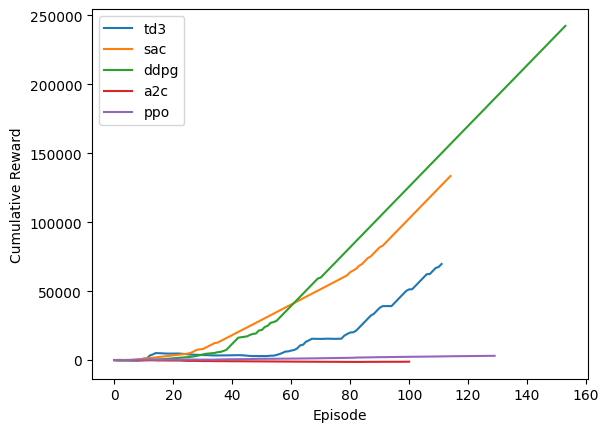

In [33]:
test = gymnasium.make(ENV_ID)
sac = SAC.load("models/sac.zip")
td3 = TD3.load("models/td3.zip")
ddpg = DDPG.load("models/ddpg.zip")
ppo = PPO.load("models/ppo.zip")
a2c = A2C.load("models/a2c.zip")

rewards = {}
rewards["td3"] = load_log("logs/td3.monitor.csv")
rewards["sac"] = load_log("logs/sac.monitor.csv")
rewards["ddpg"] = load_log("logs/ddpg.monitor.csv")
rewards["a2c"] = load_log("logs/a2c.monitor.csv")
rewards["ppo"] = load_log("logs/ppo.monitor.csv")

plot_cumulative_rewards(rewards)

Final state:


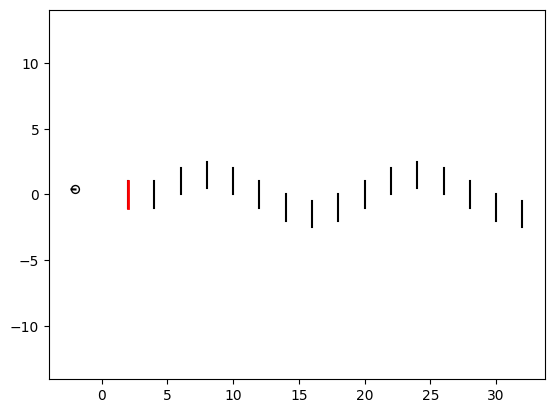

In [38]:
run_env(test, a2c)